In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip uninstall qiskit
!pip install qiskit==0.23.0
#!pip install git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src
!pip install pylatexenc

     |████████████████████████████████| 8.5 MB 14.3 MB/s 
     |████████████████████████████████| 17.5 MB 126 kB/s 
     |████████████████████████████████| 194 kB 36.6 MB/s 
     |████████████████████████████████| 203 kB 74.3 MB/s 
     |████████████████████████████████| 2.1 MB 60.1 MB/s 
     |████████████████████████████████| 200 kB 62.1 MB/s 
     |████████████████████████████████| 1.4 MB 72.4 MB/s 
     |████████████████████████████████| 635 kB 57.4 MB/s 
     |████████████████████████████████| 108 kB 72.4 MB/s 
     |████████████████████████████████| 49 kB 6.9 MB/s 
     |████████████████████████████████| 3.0 MB 49.3 MB/s 
     |████████████████████████████████| 6.3 MB 46.0 MB/s 
  Created wheel for qiskit: filename=qiskit-0.23.0-py3-none-any.whl size=2864 sha256=05bc35ef4dd6e4192cfa4ad64884666c2d6d19a126244460b078a599cb1a3622
  Stored in directory: /root/.cache/pip/wheels/cd/a7/06/813f3eb5ce09179e18fb91ddf5001bca795e9e20f1521394ab
  Created wheel for python-constraint: filename=p

In [4]:
from qiskit import execute
from qiskit.circuit import Parameter,ControlledGate
from qiskit import Aer
import qiskit
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline
import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F


if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("Running on the GPU")
else:
  device = torch.device("cpu")
  print("Running on the CPU")

Running on the CPU


In [5]:
#np.random.seed = 314

NUM_QUBITS = 4
NUM_SHOTS = 800 #3000
SHIFT = np.pi/4
LEARNING_RATE = 0.0002
MOMENTUM = 0.5

SIMULATOR = Aer.get_backend('qasm_simulator')

In [6]:
# create list of all possible outputs of quantum circuit (2**NUM_QUBITS possible)
import itertools
def create_QC_OUTPUTS():
    measurements = list(itertools.product([0, 1], repeat=NUM_QUBITS))
    return [''.join([str(bit) for bit in measurement]) for measurement in measurements]

QC_OUTPUTS = create_QC_OUTPUTS()
print(QC_OUTPUTS)

['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']


# Circuit

In [7]:
class QiskitCircuit():
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self.circuit = qiskit.QuantumCircuit(n_qubits)
        self.n_qubits = n_qubits
        self.thetas = {k : Parameter('Theta'+str(k))for k in range(2*self.n_qubits)}
        
        all_qubits = [i for i in range(n_qubits)]
        self.circuit.h(all_qubits)
        self.circuit.barrier()

        #self.circuit.h(0)

        for k in range(0, 4):
          self.circuit.ry(self.thetas[k], k)

        self.circuit.cx(0, 1)
        self.circuit.cx(0, 2)
        self.circuit.cx(0, 3)
        self.circuit.cx(1, 2)
        self.circuit.cx(1, 2)
        self.circuit.cx(2, 3)

        for k in range(0, 4):
          self.circuit.ry(self.thetas[k+4], k)

        self.circuit.measure_all()
        #self.circuit.measure(1,0)
        # ---------------------------
        
        self.backend = backend
        self.shots = shots
        
        
    def N_qubit_expectation_Z(self,counts, shots, nr_qubits):
        expects = np.zeros(len(QC_OUTPUTS))
        for k in range(len(QC_OUTPUTS)):
            key = QC_OUTPUTS[k]
            perc = counts.get(key, 0)/shots
            expects[k] = perc
        return expects
    
    def run(self, i):
        params = i
        #print('params = {}'.format(len(params)))
        backend = Aer.get_backend('qasm_simulator')
    
        job_sim = execute(self.circuit,
                              self.backend,
                              shots=self.shots,
                              parameter_binds = [{self.thetas[k] : params[k].item() for k in range(2*NUM_QUBITS)}])
#         
        result_sim = job_sim.result()
        counts = result_sim.get_counts(self.circuit)
        return self.N_qubit_expectation_Z(counts, self.shots, NUM_QUBITS)

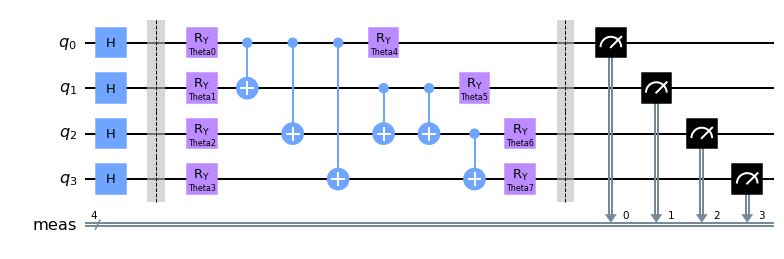

In [8]:
circuit = QiskitCircuit(NUM_QUBITS, SIMULATOR, NUM_SHOTS)
#print('Expected value for rotation [pi/4]: {}'.format(circuit.run(torch.Tensor([np.pi/4]*NUM_QUBITS))))
circuit.circuit.draw(output='mpl')#, filename='Figures/{}-qubit circuit ryN.jpg'.format(NUM_QUBITS)

In [9]:
class TorchCircuit(Function):    

    @staticmethod
    def forward(ctx, i):
        if not hasattr(ctx, 'QiskitCirc'):
            ctx.QiskitCirc = QiskitCircuit(NUM_QUBITS, SIMULATOR, shots=NUM_SHOTS)
            
        exp_value = ctx.QiskitCirc.run(i)
        
        result = torch.tensor([exp_value])
  
        ctx.save_for_backward(result, i)
        
        return result
    
    @staticmethod
    def backward(ctx, grad_output):
        
        forward_tensor, i = ctx.saved_tensors
#         print('forward_tensor = {}'.format(forward_tensor))
        input_numbers = i
#         print('input_numbers = {}'.format(input_numbers))
        gradients = torch.Tensor()
        
        for k in range(2*NUM_QUBITS):
            shift_right = input_numbers.detach().clone()
            shift_right[k] = shift_right[k] + SHIFT
            shift_left = input_numbers.detach().clone()
            shift_left[k] = shift_left[k] - SHIFT
            
#             print('shift_right = {}, shift_left = {}'.format(shift_right, shift_left))
            
            expectation_right = ctx.QiskitCirc.run(shift_right)
            expectation_left  = ctx.QiskitCirc.run(shift_left)
#             print('expectation_right = {}, \nexpectation_left = {}'.format(expectation_right, expectation_left))
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            # rescale gradient
#             gradient = gradient / torch.norm(gradient)
#             print('gradient for k={}: {}'.format(k, gradient))
            gradients = torch.cat((gradients, gradient.float()))
            
        result = torch.Tensor(gradients)
#         print('gradients = {}'.format(result))
#         print('grad_output = {}'.format(grad_output))

        return (result.float() * grad_output.float()).T

In [10]:
import sys
sys.path.append('/content/drive/MyDrive/QAI4EO/')

In [11]:
from DatasetHandler import DatasetHandler
dataset_root = '/content/drive/MyDrive/QAI4EO/datasets/EuroSAT/EuroSAT'
handler = DatasetHandler(dataset_root)

In [12]:
classes = []
for i, c in enumerate(handler.classes):
  cl = c.split('/')[-1]
  classes.append(cl)
classes.sort()
classes

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [13]:
classes = ['River', 'SeaLake']

In [14]:
imgs_path, imgs_label = handler.load_paths_labels(dataset_root, classes=classes)
print('Dataset images:', len(imgs_path), 'Dataset labels:', len(imgs_label))
print('Dataset sample ->', imgs_path[0], imgs_label[0])

Dataset images: 5500 Dataset labels: 5500
Dataset sample -> /content/drive/MyDrive/QAI4EO/datasets/EuroSAT/EuroSAT/River/River_365.jpg 8


In [15]:
train_imgs, train_labels, val_images, val_labels = handler.train_validation_split(imgs_path, imgs_label, split_factor=0.2)
print('X_train shape:', train_imgs.shape, 'Y_train shape:', train_labels.shape)
print('  X_val shape: ', val_images.shape, '  Y_val shape: ', val_labels.shape)

X_train shape: (4400,) Y_train shape: (4400,)
  X_val shape:  (1100,)   Y_val shape:  (1100,)


(array([2500.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        3000.]),
 array([8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. ]),
 <a list of 10 Patch objects>)

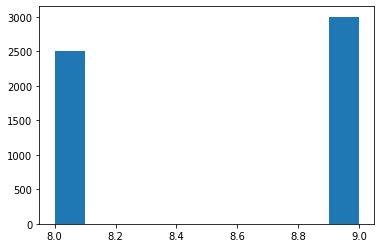

In [16]:
plt.hist(imgs_label, 10)

In [17]:
for i in range(len(train_labels)):
  lr = train_labels[i]
  l = 0

  if lr == 8:
    l = 0
  elif lr == 9:
    l = 1
  
  train_labels[i] = l

for i in range(len(val_labels)):
  lr = val_labels[i]
  l = 0

  if lr == 8:
    l = 0
  elif lr == 9:
    l = 1
  
  val_labels[i] = l

(array([2500.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        3000.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

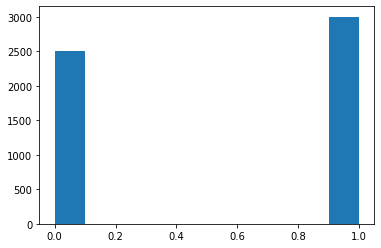

In [ ]:
plt.hist(imgs_label, 10)

In [18]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)

        #self.conv2_drop = nn.Dropout2d()

        self.fc1 = nn.Linear(2304, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 42)

        self.fc4 = nn.Linear(2304, 2*NUM_QUBITS)
        
        self.qc = TorchCircuit.apply

        #self.fc5 = nn.Linear(16, 10)
        self.fc5 = nn.Linear(16, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))

        x = x.view(-1, 2304)
        #x = F.relu(self.fc1(x))
        #x = F.dropout(x, training=self.training)
        #x = F.relu(self.fc2(x))

        #x = F.relu(self.fc3(x))

        x = self.fc4(x)
        x = np.pi*torch.tanh(x)
        
        x = self.qc(x[0]) # QUANTUM LAYER
        
        x = F.relu(x)
        #print('output of QC = {}'.format(x))
        
#         # softmax rather than sigmoid
        x = self.fc5(x.float())
        #print('output of Linear(1, 2): {}'.format(x))
        x = F.softmax(x, 1)

        #x = torch.sigmoid(x)
        #x = torch.cat((x, 1-x), -1)
        return x
    
    
    def predict(self, x):
        # apply softmax
        pred = self.forward(x)
#         print(pred)
        ans = torch.argmax(pred[0]).item()
        return torch.tensor(ans)
    
network = Net()#.to(device)
optimizer = optim.Adam(network.parameters(), lr=0.0002)

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

#from torchsummary import summary
#summary(network, (3, 64, 64))

In [20]:
train_loader = iter(handler.qcnn_data_loader(train_imgs, train_labels, batch_size = 1, img_shape = (64,64,3)))
test_loader = iter(handler.qcnn_data_loader(val_images, val_labels, batch_size = 1, img_shape = (64,64,3)))

In [21]:
checkpoint = torch.load('/content/drive/MyDrive/QAI4EO/model-real-amp-group3.pt')
network.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [ ]:
train_loss_list = []
val_loss_list = []
epochs = 25

loss_func = nn.CrossEntropyLoss()

for epoch in range(epochs):
  train_loader = iter(handler.qcnn_data_loader(train_imgs, train_labels, batch_size = 1, img_shape = (64,64,3)))
  test_loader = iter(handler.qcnn_data_loader(val_images, val_labels, batch_size = 1, img_shape = (64,64,3)))
  total_loss = []
  for batch_idx in range(len(train_labels)):
    data, target = next(train_loader) 
    # print(batch_idx)
    optimizer.zero_grad()        
    # Forward pass
    output = network(data)
    # Calculating loss
    loss = loss_func(output, target)
    # Backward pass
    loss.backward()
    # Optimize the weights
    optimizer.step()
    
    total_loss.append(loss.item())
    
    print('\r Epoch %d ~ Batch %d (%d) ~ Loss %f ' % (epoch, batch_idx, len(train_imgs)-1, loss.item()), end='\t\t')
    
  
  with torch.no_grad():
    val_loss = []
    targets = []
    predictions = []
    for batch_idx in range(len(val_images)):
      data, target = next(test_loader)
      output = network(data)
      loss = loss_func(output, target)
      val_loss.append(loss.item())

      targets.append(target.item())
      
      predictions.append(network.predict(data).item())
  
      
  train_loss_list.append(sum(total_loss)/len(total_loss))
  val_loss_list.append(sum(val_loss)/len(val_loss))
  
  print('Training [{:.0f}%]\t Training Loss: {:.4f} Validation Loss: {:.4f}'.format(
      100. * (epoch + 1) / epochs, train_loss_list[-1], val_loss_list[-1]))
  
  if epoch % 3 == 1:
    print(confusion_matrix(targets, predictions,normalize='true'))
    print(classification_report(targets, predictions, target_names=classes, digits=4))
    torch.save({
            'epoch': epoch,
            'model_state_dict': network.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss_list[-1],
            }, '/content/drive/MyDrive/QAI4EO/model-real-amp-group3.pt')
    #torch.save(network.state_dict(), '/content/drive/MyDrive/QAI4EO/model-bell.pt')

 Epoch 0 ~ Batch 4399 (4399) ~ Loss 0.596213 		Training [4%]	 Training Loss: 0.5739 Validation Loss: 0.4911
 Epoch 1 ~ Batch 4399 (4399) ~ Loss 0.381110 		Training [8%]	 Training Loss: 0.4418 Validation Loss: 0.3959
[[0.98971193 0.01028807]
 [0.03420195 0.96579805]]
              precision    recall  f1-score   support

       River     0.9582    0.9897    0.9737       486
     SeaLake     0.9916    0.9658    0.9785       614

    accuracy                         0.9764      1100
   macro avg     0.9749    0.9778    0.9761      1100
weighted avg     0.9769    0.9764    0.9764      1100

 Epoch 2 ~ Batch 4399 (4399) ~ Loss 0.343337 		Training [12%]	 Training Loss: 0.3849 Validation Loss: 0.3672
 Epoch 3 ~ Batch 4399 (4399) ~ Loss 0.323068 		Training [16%]	 Training Loss: 0.3554 Validation Loss: 0.3461
 Epoch 4 ~ Batch 4399 (4399) ~ Loss 0.318264 		Training [20%]	 Training Loss: 0.3445 Validation Loss: 0.3564
[[0.94117647 0.05882353]
 [0.008726   0.991274  ]]
              precision    r

KeyboardInterrupt: ignored

In [ ]:
fig, plt.plot(train_loss_list)
plt.plot(val_loss_list)
plt.title('Hybrid NN Training Convergence for {}-qubit'.format(NUM_QUBITS))
plt.xlabel('Training Iterations')
plt.ylabel('Cross Entropy Loss')
plt.legend(['Training', 'Validation'])
plt.show()

# Save results

In [23]:
import pandas as pd

In [22]:
checkpoint = torch.load('/content/drive/MyDrive/QAI4EO/model-real-amp-group3.pt')
network.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [24]:
coarse_db = pd.read_csv('/content/drive/MyDrive/QAI4EO/coarse_classification.csv')

In [25]:
coarse_db.head()

,Unnamed: 0,PATH,TARGET,FULLTARGET,PREDICTION
0,0,/content/drive/MyDrive/QAI4EO/datasets/EuroSAT...,0,0,0
1,1,/content/drive/MyDrive/QAI4EO/datasets/EuroSAT...,2,8,2
2,2,/content/drive/MyDrive/QAI4EO/datasets/EuroSAT...,0,2,0
3,3,/content/drive/MyDrive/QAI4EO/datasets/EuroSAT...,1,4,1
4,4,/content/drive/MyDrive/QAI4EO/datasets/EuroSAT...,2,9,2


In [26]:
val_images = coarse_db.PATH.values
full_targets = coarse_db.FULLTARGET.values
coarse_prediction = coarse_db.PREDICTION.values

In [28]:
batch_in = np.zeros((1, 3, 64, 64))

full_targets2 = []

with torch.no_grad():
  predictions = []
  for batch_idx in range(len(val_images)):

    if coarse_prediction[batch_idx] == 2:
      batch_in[0,...] = np.transpose(plt.imread(val_images[batch_idx])/255.0)
      output = network.predict(torch.Tensor(batch_in)).item()
      predictions.append(output)
      full_targets2.append(full_targets[batch_idx])

    print('\r  IMG: %d of %d' % (batch_idx, len(val_images)), end='\t\t')
    

  IMG: 0 of 5399		

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


  IMG: 5398 of 5399		

In [29]:
len(full_targets2)

1114

In [30]:
len(predictions)

1114

In [31]:
full_targets3 = []

for i in range(len(full_targets2)):
  lr = full_targets2[i]
  
  l = 0

  if lr == 8:
    l = 0
  elif lr == 9:
    l = 1

  full_targets3.append(l)

In [33]:
print(confusion_matrix(full_targets3, predictions,normalize='true'))
print(classification_report(full_targets3, predictions, target_names=['River','SeaLake'], digits=4))

[[0.97286822 0.02713178]
 [0.00668896 0.99331104]]
              precision    recall  f1-score   support

       River     0.9921    0.9729    0.9824       516
     SeaLake     0.9770    0.9933    0.9851       598

    accuracy                         0.9838      1114
   macro avg     0.9845    0.9831    0.9837      1114
weighted avg     0.9840    0.9838    0.9838      1114



In [35]:
np.array([0.93, 0.97, 0.92, 0.93, 0.91, 0.99, 0.99, 0.99, 0.99, 0.99]).mean()

0.961